In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
dfTrain = pd.read_csv('./mnist_train.csv', header=None)
dfTest = pd.read_csv('./mnist_test.csv', header=None)

In [134]:
print(f'Train set shape: {dfTrain.shape}')
print(f'Test set shape: {dfTest.shape}')
# dfTrain.head()
dfTest.head()

Train set shape: (60000, 785)
Test set shape: (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
dfTrain = dfTrain.rename(columns={0: 'train'})
dfTest = dfTest.rename(columns={0: 'test'})

In [136]:
X_train = dfTrain.drop(['train'],axis=1)
y_train = dfTrain['train']
X_test = dfTest.drop(['test'],axis=1)
y_test = dfTest['test']

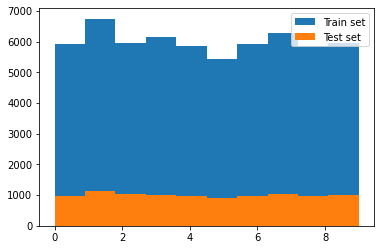

In [137]:
plt.hist(y_train, label='Train set')
plt.hist(y_test, label='Test set')
plt.legend()

In [138]:
def show_image(pixels):
  img = np.reshape(pixels, (28, 28))
  plt.imshow(img, cmap='plasma')

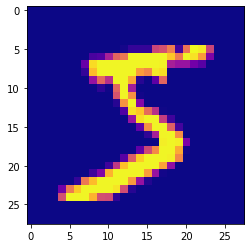

In [139]:
show_image(X_train.iloc[0].values)

In [140]:
y_train.mean()

4.4539333333333335

In [141]:
df_digits_distribution = pd.concat([y_train.value_counts().sort_index(), y_test.value_counts().sort_index()], axis=1)
df_digits_distribution

,train,test
0,5923,980
1,6742,1135
2,5958,1032
3,6131,1010
4,5842,982
5,5421,892
6,5918,958
7,6265,1028
8,5851,974
9,5949,1009


<AxesSubplot:xlabel='train', ylabel='Count'>

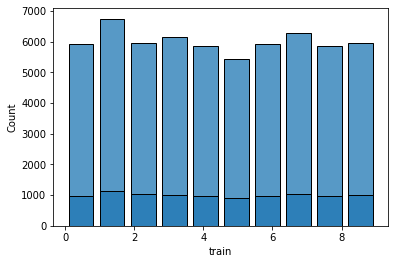

In [169]:
sns.histplot(dfTrain, x='train', bins=10, shrink=.8)
sns.histplot(dfTest, x='test', bins=10, shrink=.8)